# <center>Privacy-Preserving Fraud Detection in Banking Using Horizontal Federated Learning</center>

---- 
## Problem Statement:

Fraud detection is a critical challenge for financial institutions, often requiring centralized machine learning models that aggregate sensitive customer data, raising privacy and compliance concerns. Horizontal Federated Learning (HFL) offers a solution by enabling collaborative model training across multiple bank branches or institutions without sharing raw data.

This research project focuses on developing a privacy-preserving HFL framework for fraud detection using the Bank Account Fraud (BAF) dataset. The goal is to address challenges such as data heterogeneity, privacy preservation, and computational efficiency while ensuring high model accuracy and fairness. The framework's effectiveness will be evaluated to demonstrate its practical viability for real-world banking scenarios.

In [27]:
#%pip install watermark flwr

In [28]:
%load_ext autoreload 
%load_ext watermark 

%watermark -p pandas,flwr
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
pandas: 2.0.3
flwr  : 1.14.0



In [29]:
import os 
import sys 

sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.paths import DATA_DIR, CLIENTS_DATA_DIR 
from src.config import BASE_DATA
from src.local_utility import EDAPlotter

--- 

## EDA 

In [30]:
base_df = pd.read_csv(BASE_DATA)
base_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [31]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [32]:
%%time 

overview_df = pd.DataFrame(columns = ["feature", "NaN", "Unique", "N-Unique", "Min", "Data Type"])
for i, col in enumerate(base_df.columns):
    overview_df.loc[i] = [col, base_df[col].isna().sum(), base_df[col].unique(), 
                          base_df[col].nunique(), base_df[col].min(), base_df[col].dtypes]

overview_df 

CPU times: total: 6.64 s
Wall time: 6.83 s


,feature,NaN,Unique,N-Unique,Min,Data Type
0,fraud_bool,0,"[1, 0]",2,0.0,int64
1,income,0,"[0.9, 0.3, 0.7000000000000001, 0.6000000000000...",9,0.1,float64
2,name_email_similarity,0,"[0.1668277344243326, 0.2962860052333516, 0.044...",998861,0.000001,float64
3,prev_address_months_count,0,"[-1, 92, 172, 28, 289, 35, 55, 194, 103, 27, 3...",374,-1.0,int64
4,current_address_months_count,0,"[88, 144, 132, 22, 218, 30, 152, 18, 64, 60, 1...",423,-1.0,int64
5,customer_age,0,"[50, 40, 30, 20, 70, 60, 80, 10, 90]",9,10.0,int64
6,days_since_request,0,"[0.0209251728365947, 0.0054175383255355, 3.108...",989330,0.0,float64
7,intended_balcon_amount,0,"[-1.3313449634902534, -0.8162237547762208, -0....",994971,-15.530555,float64
8,payment_type,0,"[AA, AB, AC, AD, AE]",5,AA,object
9,zip_count_4w,0,"[769, 366, 870, 810, 890, 732, 876, 901, 933, ...",6306,1,int64


----
**Observations I** 

- Almost every feature in the dataset passed the first sanity check except for a few
- `device_fraud_count` has just a single value so we need to get rid of it
- `prev_address_months_count` seems off with a `-1` value.
- `prev_address_months_count` feature captured the number of months an applicant stayed in their previous registered house address / residence, hence `-1` is a missing value here.
- `current_address_months_count` captured months an applicant has stayed in their current registered address. `-1` herein is also a missing value.
- `bank_months_count` captured how long (in months) an applicant has been using the bank account. A `-1` herein is also a missing value.
- `session_length_in_minutes` captured how long (in minutes) a user spends on the banking website. `-1` herein is also a missing value.
- `device_distinct_emails_8w` captured number of unique emails recieved/sent by the bank from the user's current device in last 8 weeks. `-1` herein is also a missing value.
- The minimum customer's age is 10. Can a 10 year old kid make bank transcations? Requires more investigation
- `velocity_6h` has a negative value. Velocity, in a financial or transactional context, typically refers to the rate or count of events (e.g., transactions) over a 6 hours period. Negative values for velocity are generally not meaningful, as velocity represents a magnitude or rate that cannot logically be less than zero.
--- 
 

 



In [33]:
base_df.describe().T 

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


In [34]:
# Descriptive stats of non-numerical columns (object & boolean)
base_df.describe(include=['O', "B"])

,payment_type,employment_status,housing_status,source,device_os
count,1000000,1000000,1000000,1000000,1000000
unique,5,7,7,2,5
top,AB,CA,BC,INTERNET,other
freq,370554,730252,372143,992952,342728



**Observations II**
- Didn't pick up any new odd value here other than what has been observed in the first observation.

--- 

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

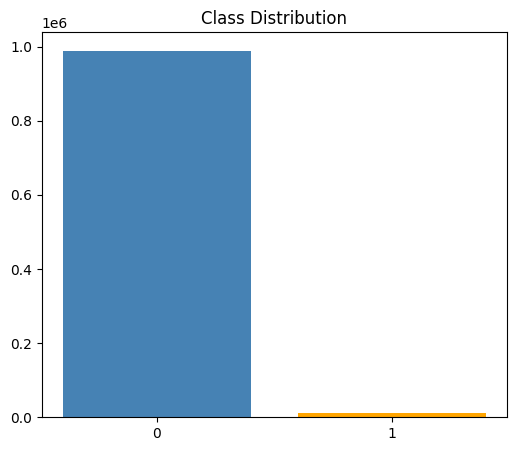

In [35]:
counts = base_df["fraud_bool"].value_counts()
display(counts) 

labels = counts.index.astype(str) 
values = counts.values

plt.figure(figsize=(6, 5))
plt.bar(labels, values, color=["steelblue", "orange"])
plt.title("Class Distribution")
plt.show(); 

As expected we have a class imbalance problem; a severe one if I might add.

----

Missing values are represented by `-1` we'll leave it as it were.

In [36]:
df = base_df.copy() 

In [37]:
cols_missing = ["prev_address_months_count", "current_address_months_count", "bank_months_count", 
                "session_length_in_minutes", "device_distinct_emails_8w"]

In [38]:
eda_plotter = EDAPlotter()

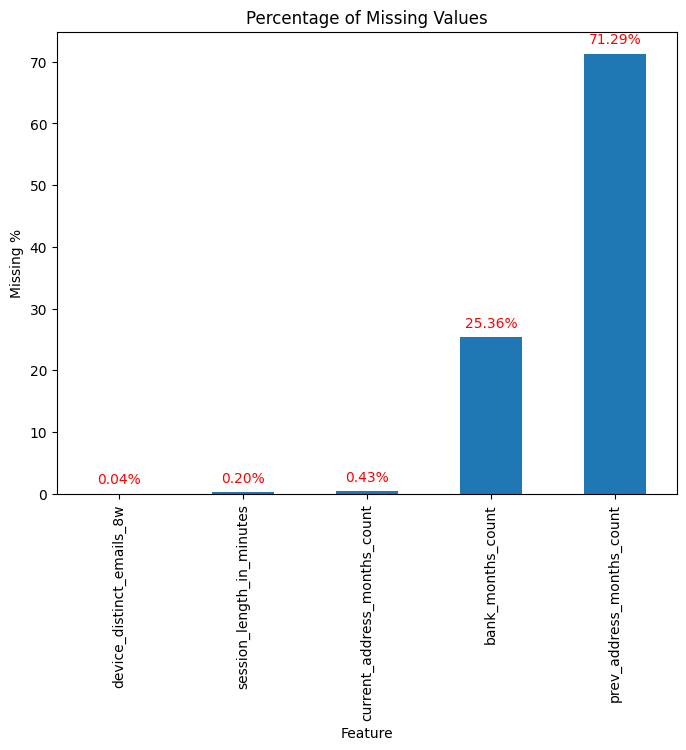

In [39]:
eda_plotter.plot_missing_values_proportion(df, cols_missing)

-----

**Numerical Feature Distribution**  

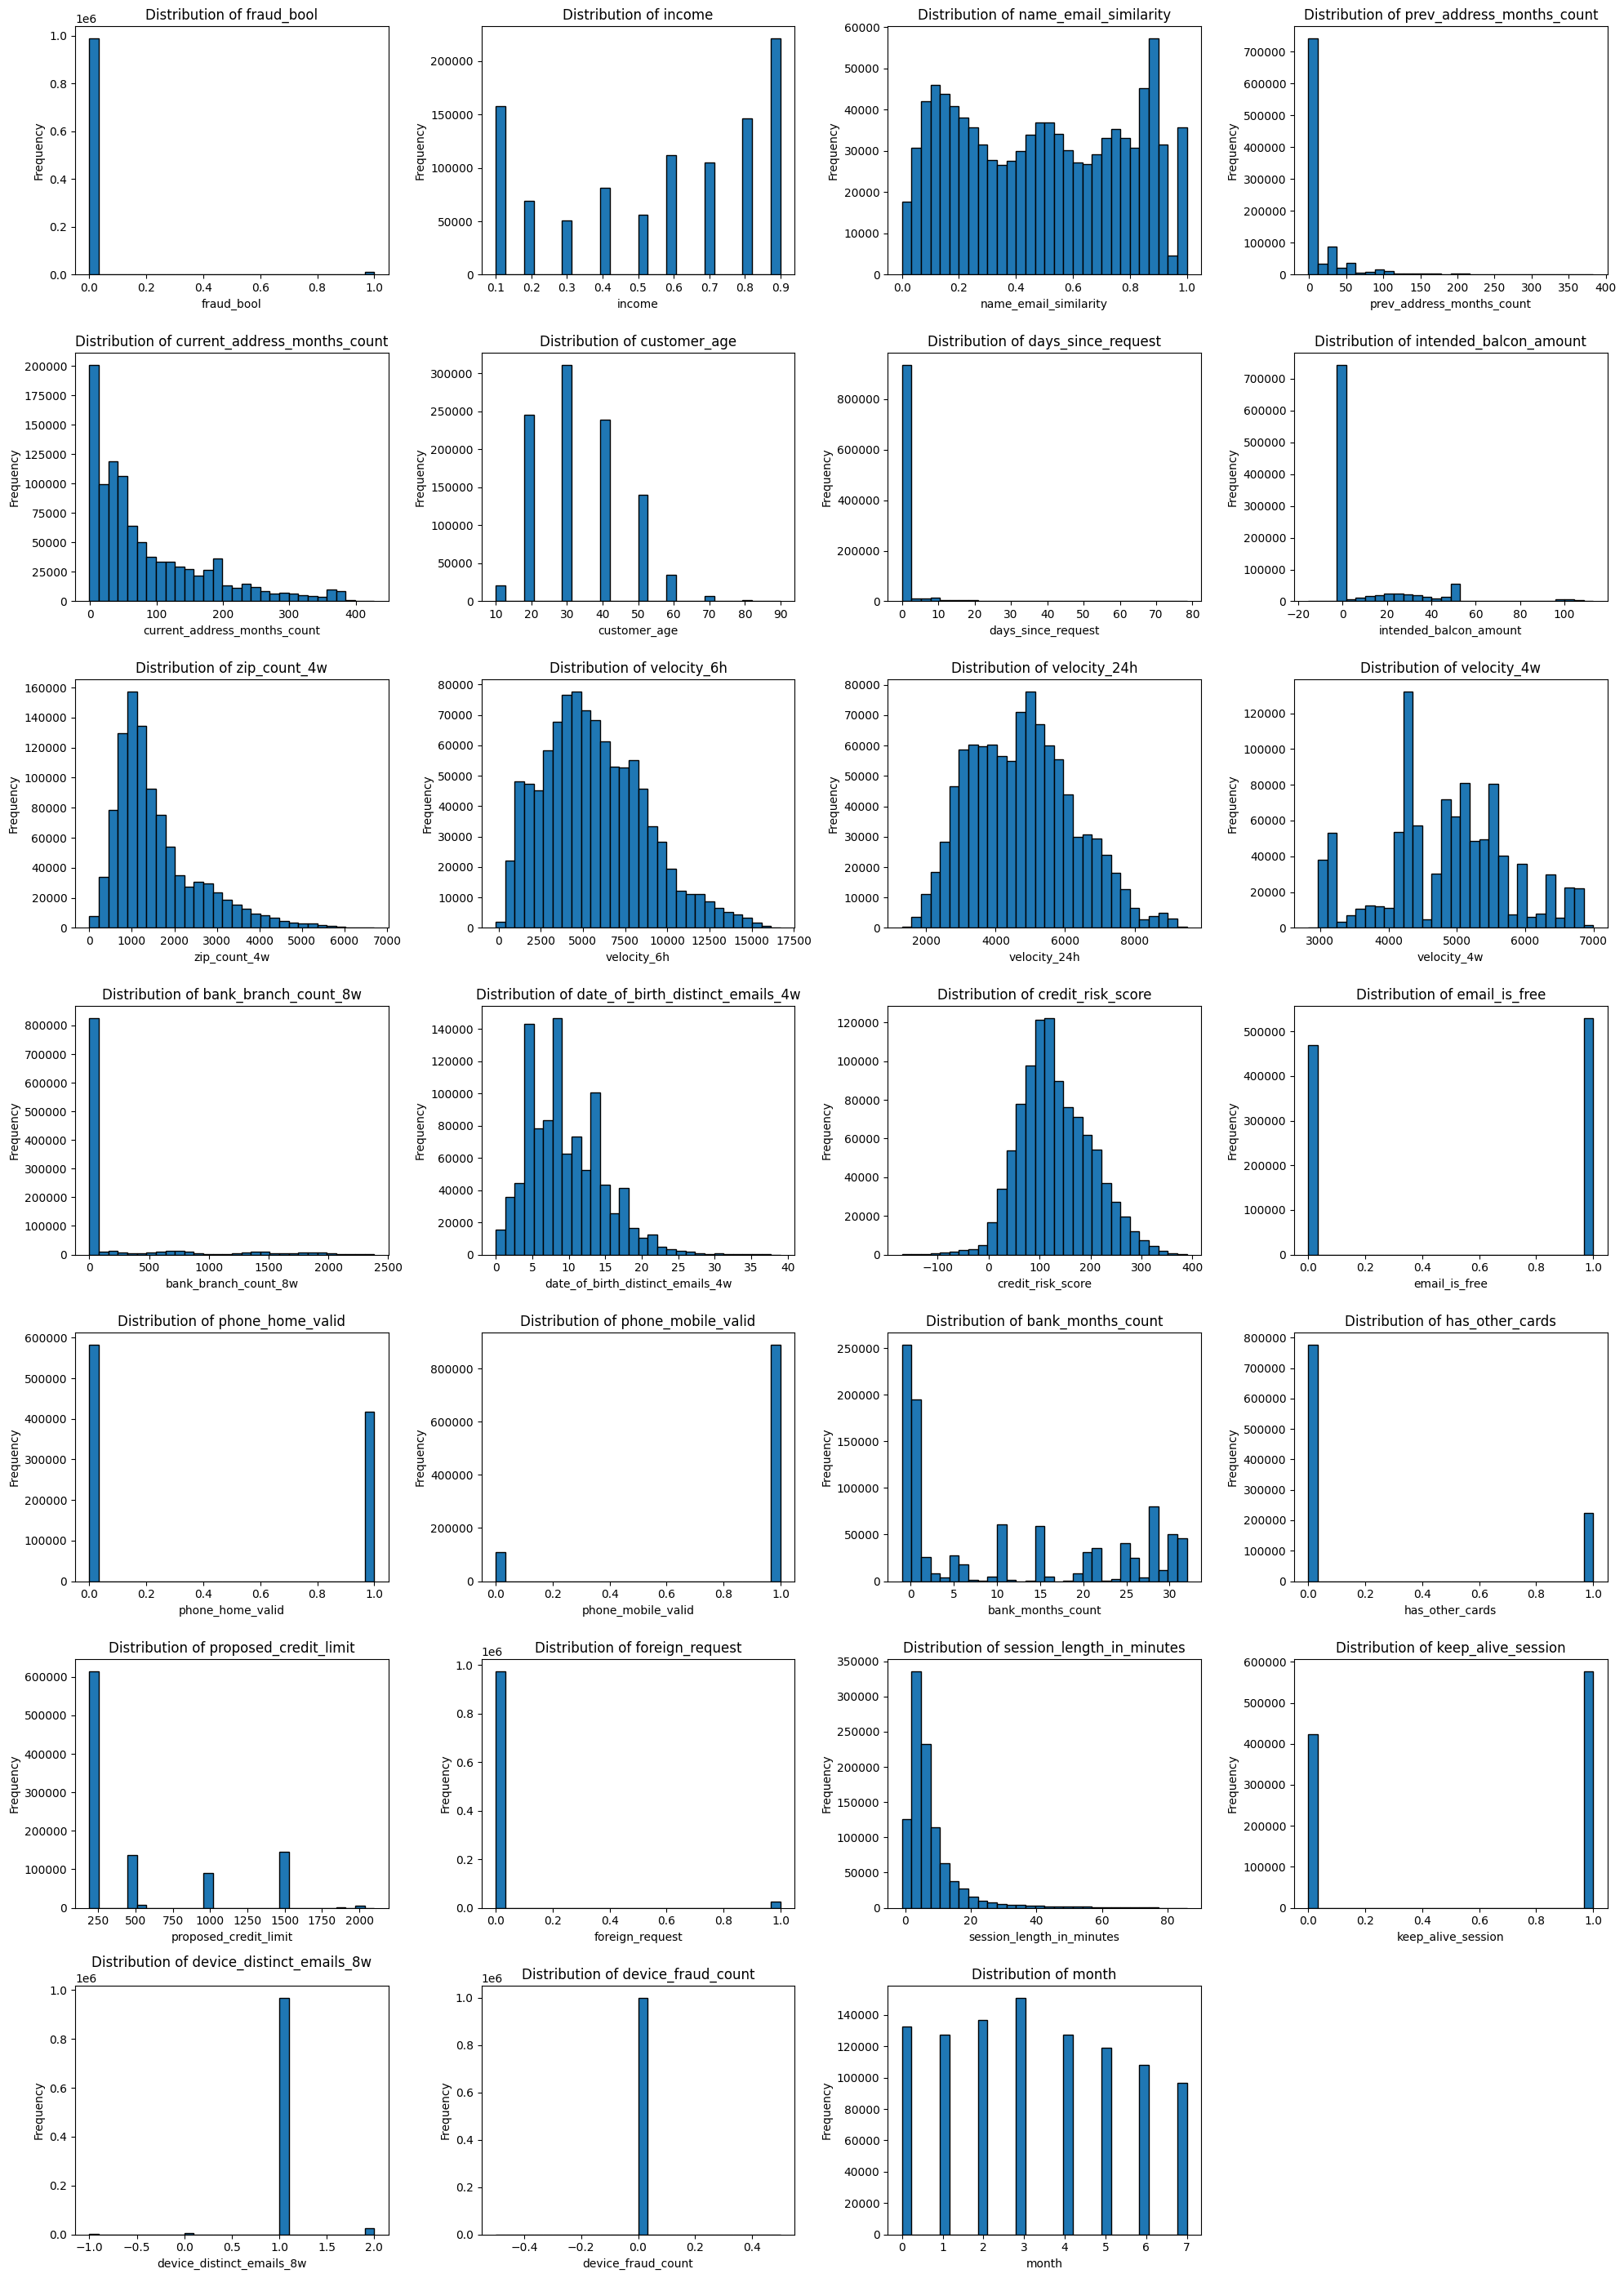

In [40]:
eda_plotter.plot_numerical_features(df) 

---- 

**Categorical Feature Distribution**  

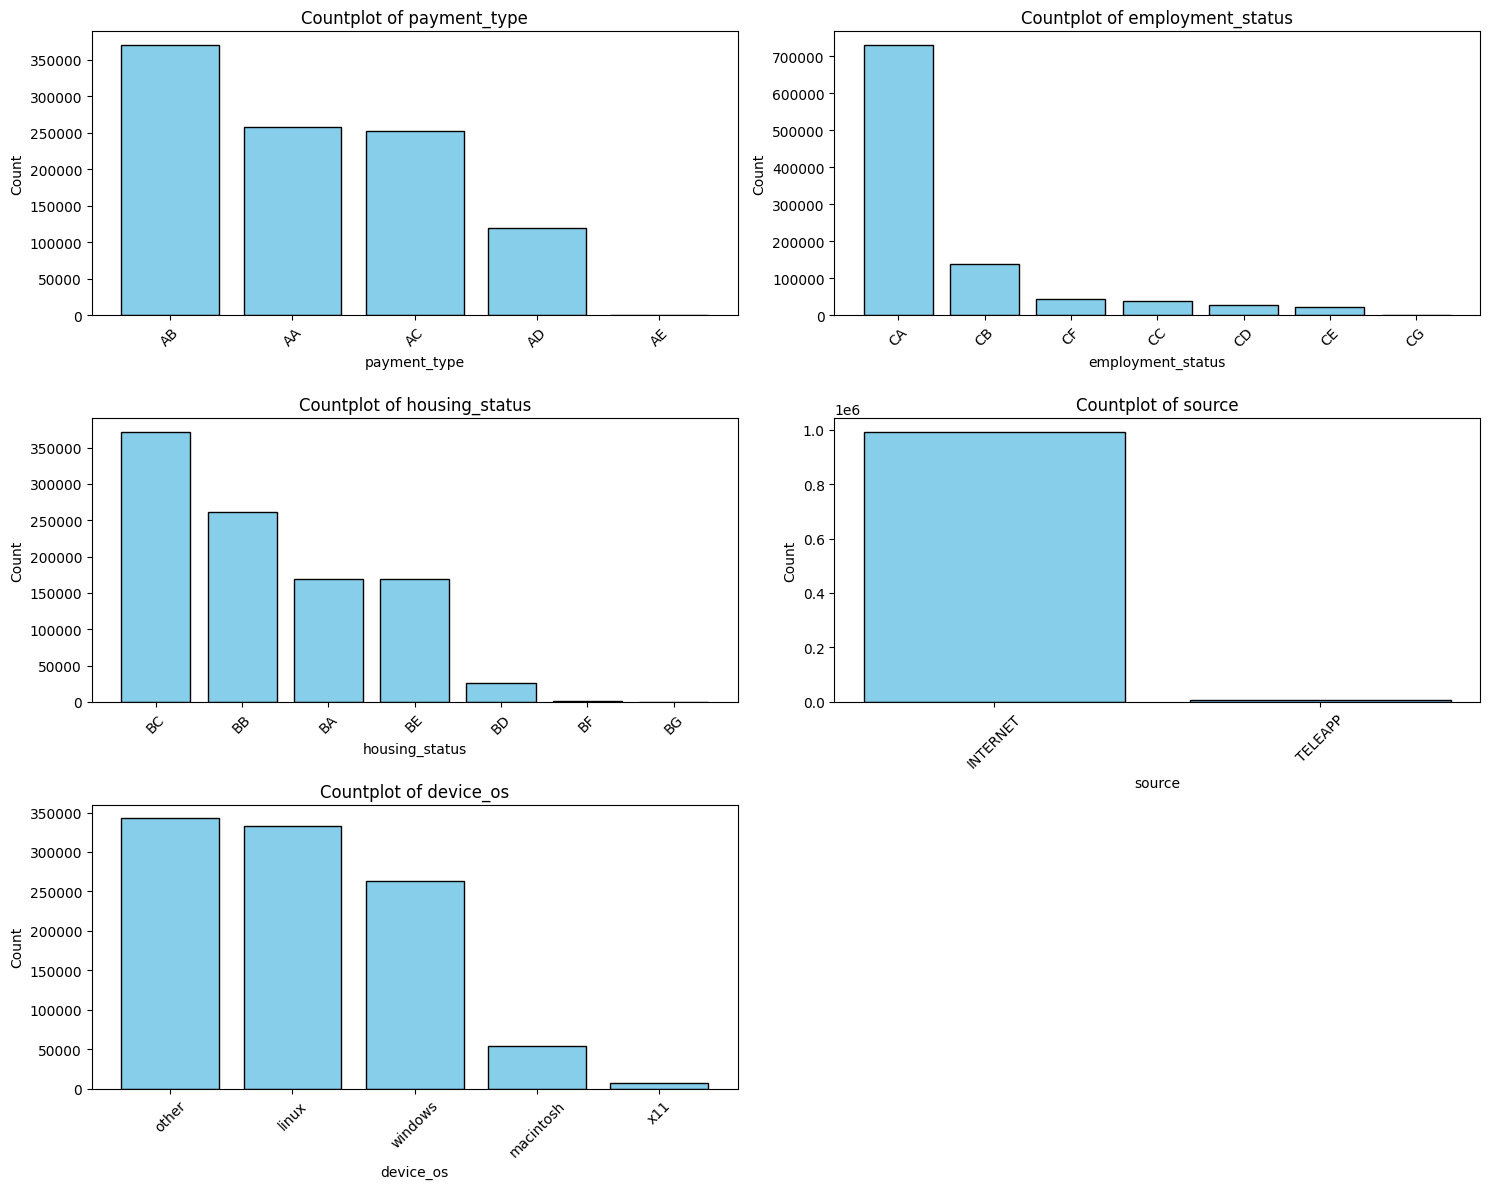

In [41]:
eda_plotter.plot_categorical_features(df) 

---- 

**Skewness**  

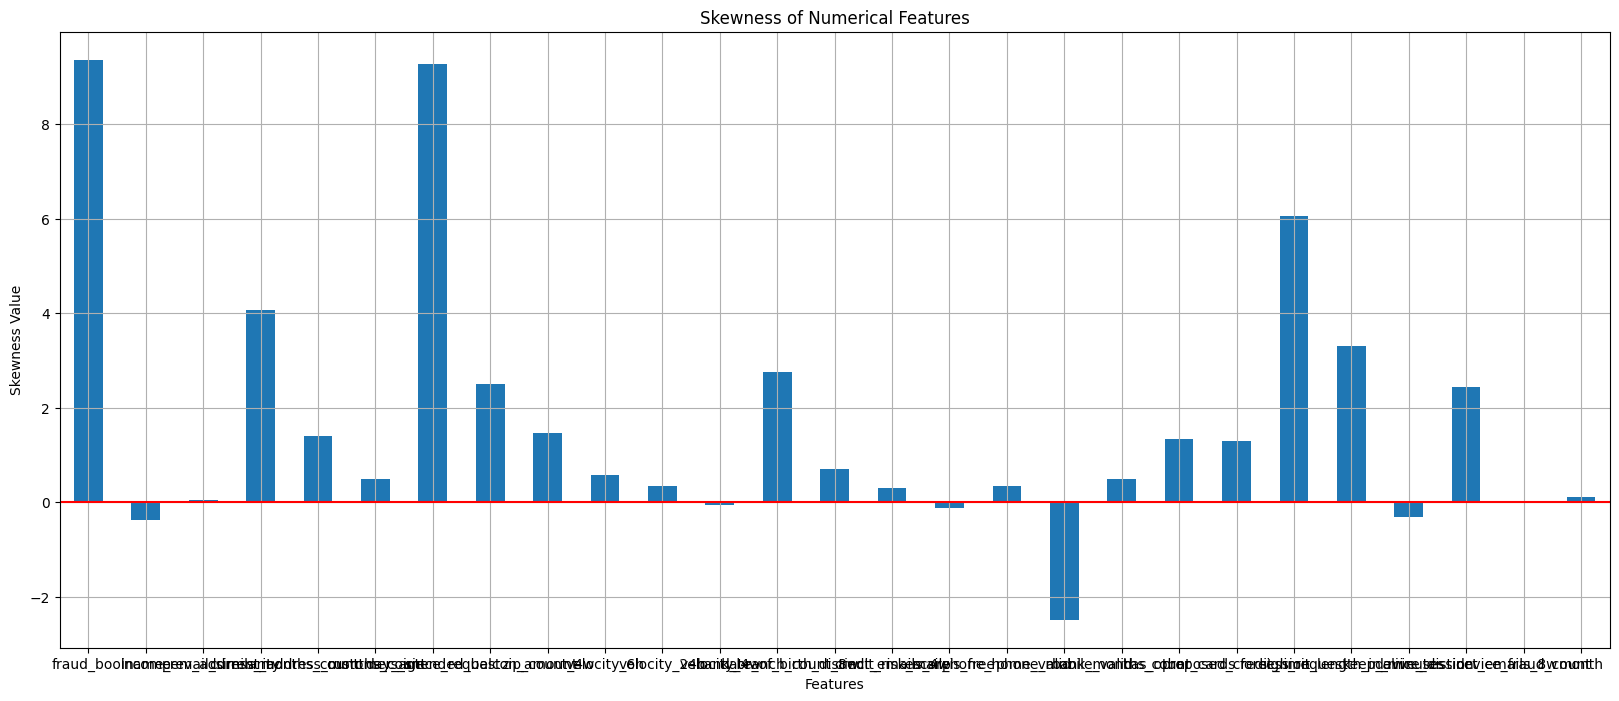

fraud_bool                          9.363838
income                             -0.386337
name_email_similarity               0.042839
prev_address_months_count           4.063888
current_address_months_count        1.386998
customer_age                        0.478079
days_since_request                  9.278955
intended_balcon_amount              2.507173
zip_count_4w                        1.456657
velocity_6h                         0.562682
velocity_24h                        0.331134
velocity_4w                        -0.060125
bank_branch_count_8w                2.747161
date_of_birth_distinct_emails_4w    0.703250
credit_risk_score                   0.295895
email_is_free                      -0.119758
phone_home_valid                    0.336350
phone_mobile_valid                 -2.487616
bank_months_count                   0.488747
has_other_cards                     1.330989
proposed_credit_limit               1.301410
foreign_request                     6.053306
session_le

In [42]:
eda_plotter.plot_skewness(df) 

---

## Separate Numeric & Categorical Features

In [43]:
df.select_dtypes(include=np.number).columns 

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
       'month'],
      dtype='object')

In [44]:
df.select_dtypes(exclude=np.number).columns 

Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')

In [45]:
cat_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

num_cols = ['income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
       'month']

In [46]:
# How does categorical features look like

for col in cat_cols:
    print(df[col].value_counts())
    print('')

payment_type
AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: count, dtype: int64

employment_status
CA    730252
CB    138288
CF     44034
CC     37758
CD     26522
CE     22693
CG       453
Name: count, dtype: int64

housing_status
BC    372143
BB    260965
BA    169675
BE    169135
BD     26161
BF      1669
BG       252
Name: count, dtype: int64

source
INTERNET    992952
TELEAPP       7048
Name: count, dtype: int64

device_os
other        342728
linux        332712
windows      263506
macintosh     53826
x11            7228
Name: count, dtype: int64



-----

## Handling Class Imbalance

In [47]:
from src.config import SEED

In [48]:
sampled_neg = df[df['fraud_bool'] == 0].sample(frac=0.02, random_state=SEED)
positive_class = df[df['fraud_bool'] == 1]

In [49]:
len(sampled_neg)

19779

In [50]:
downsampled_df = pd.concat([positive_class, sampled_neg], axis=0).sample(frac=1).reset_index(drop=True)

In [51]:
downsampled_df 

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.6,0.759581,-1,49,60,0.029111,-1.677065,AB,886,...,1,500.0,0,INTERNET,1.699338,linux,0,1,0,5
1,1,0.9,0.413196,-1,188,40,0.021311,-0.423311,AB,2174,...,0,1500.0,0,INTERNET,3.892208,windows,0,1,0,7
2,0,0.9,0.527018,13,3,20,0.043816,51.131611,AA,1125,...,0,500.0,0,INTERNET,4.689088,macintosh,0,1,0,3
3,1,0.8,0.891709,-1,74,40,0.023161,21.852144,AA,872,...,0,1500.0,0,INTERNET,15.177750,windows,0,1,0,2
4,0,0.9,0.404491,-1,78,30,0.020393,-0.911295,AB,1311,...,0,200.0,0,INTERNET,7.687877,windows,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30803,1,0.8,0.698514,-1,154,50,0.012263,-0.557580,AA,895,...,0,2000.0,0,INTERNET,3.613473,other,1,1,0,7
30804,0,0.9,0.228335,-1,21,40,3.867462,-0.927913,AC,1406,...,0,200.0,0,INTERNET,8.011541,windows,0,1,0,1
30805,0,0.1,0.722089,31,4,20,0.013510,-1.021095,AC,1179,...,0,200.0,0,INTERNET,3.428016,macintosh,1,1,0,5
30806,0,0.4,0.608771,-1,18,20,0.019903,-1.396401,AD,1473,...,0,1500.0,0,INTERNET,5.220924,other,1,1,0,1


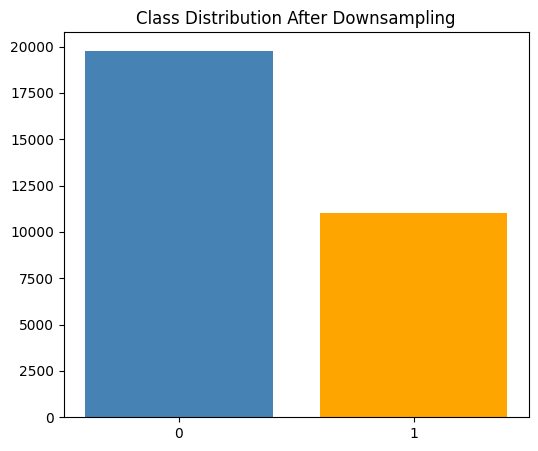

In [52]:
counts = downsampled_df["fraud_bool"].value_counts()
 
labels = counts.index.astype(str) 
values = counts.values

plt.figure(figsize=(6, 5))
plt.bar(labels, values, color=["steelblue", "orange"])
plt.title("Class Distribution After Downsampling")
plt.show(); 

In [53]:
downsampled_df.to_csv(f"{DATA_DIR}/base_downsampled.csv", index=False) #<--- Export to CSV

---- 

## Simulate Federated Learning Dataset

In [57]:
from src.data_prep import simulate_dataset

In [59]:
simulate_dataset() 

Simulating Federated Learning Dataset for 5 Clients ...
All checks passed successfully.
Dataset preparation and validation completed successfully.
